In [1]:
!pip install xgboost

In [25]:
# Import our dependencies
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import numpy as np

#models
from xgboost import XGBRegressor

#  Import and read the charity_data.csv.
import pandas as pd

# Get data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Data

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/energy_weather_joined.csv')
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 05:00:00+01:00,410.0,178.0,0.0,4038.0,3590.0,156.0,0.0,0.0,0.0,...,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 07:00:00+01:00,408.0,172.0,0.0,4030.0,3208.0,160.0,0.0,0.0,0.0,...,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 11:00:00+01:00,421.0,226.0,0.0,3931.0,3845.0,166.0,0.0,0.0,0.0,...,1,255,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [4]:
# get the columns name as reference for below
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed',

In [5]:
df=df.drop(["generation marine", "generation wind offshore", "forecast solar day ahead", "forecast wind onshore day ahead", "forecast wind onshore day ahead", "forecast wind offshore eday ahead", "total load forecast", "price day ahead", "generation hydro pumped storage aggregated"], axis=1)

In [6]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 05:00:00+01:00,410.0,178.0,0.0,4038.0,3590.0,156.0,0.0,0.0,0.0,...,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 07:00:00+01:00,408.0,172.0,0.0,4030.0,3208.0,160.0,0.0,0.0,0.0,...,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 11:00:00+01:00,421.0,226.0,0.0,3931.0,3845.0,166.0,0.0,0.0,0.0,...,1,255,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [7]:
df=df.drop(["weather_id", "weather_icon", "weather_description", "weather_main", "temp_min", "city_name", "temp_max"], axis=1)
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,65.41,270.475,1001,77,1,62,0.0,0.0,0.0,0
1,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,56.04,269.686,1002,78,0,23,0.0,0.0,0.0,0
2,2015-01-01 05:00:00+01:00,410.0,178.0,0.0,4038.0,3590.0,156.0,0.0,0.0,0.0,...,53.63,270.292,1004,71,2,321,0.0,0.0,0.0,0
3,2015-01-01 07:00:00+01:00,408.0,172.0,0.0,4030.0,3208.0,160.0,0.0,0.0,0.0,...,51.43,270.292,1004,71,2,321,0.0,0.0,0.0,0
4,2015-01-01 11:00:00+01:00,421.0,226.0,0.0,3931.0,3845.0,166.0,0.0,0.0,0.0,...,59.86,284.824,1006,55,1,255,0.0,0.0,0.0,0


In [8]:
#split time (datetime format) column into date and time
datetimezone = df['time'].astype("string")
datelist = []
timelist = []

for datetimerow in datetimezone:
    date, time = datetimerow.split(" ", 1)
    time, timezone = time.split("+", 1)
    datelist.append(date)
    timelist.append(time)

In [9]:
monthlist = []
daylist = []

for date in datelist:
  year, yearless = date.split("-", 1)
  month, day = yearless.split("-", 1)
  daylist.append(day)
  monthlist.append(month)

df['day'] = daylist
df['month'] = monthlist

In [10]:
hourlist = []

for time in timelist:
  hour, hourless = time.split(":", 1)
  hourlist.append(hour)

df['hour'] = hourlist

In [11]:
df=df.drop(["time"], axis=1)

In [12]:
df['month'] = df['month'].astype('int')
df['day'] = df['day'].astype('int')
df['hour'] = df['hour'].astype('int')

In [26]:
df.isnull().sum()

generation biomass                              95
generation fossil brown coal/lignite            90
generation fossil coal-derived gas              90
generation fossil gas                           90
generation fossil hard coal                     90
generation fossil oil                           95
generation fossil oil shale                     90
generation fossil peat                          90
generation geothermal                           90
generation hydro pumped storage consumption     95
generation hydro run-of-river and poundage      95
generation hydro water reservoir                90
generation nuclear                              85
generation other                                90
generation other renewable                      90
generation solar                                90
generation waste                                95
generation wind onshore                         90
total load actual                              180
price actual                   

In [27]:
df.dropna(inplace=True)

# Machine Learning Regression model

In [28]:
# Convert categorical data to numeric with `pd.get_dummies`
dummies = pd.get_dummies(df.loc[:,df.columns != "price actual"])

In [29]:
# Split our preprocessed data into our features and target arrays
y = df["price actual"].values
#X = application_df.drop(["IS_SUCCESSFUL"],axis=1).values
X = dummies
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [30]:
model = XGBRegressor()

In [31]:
#X = df.loc[:,df.columns != "price actual"]
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [32]:
score = model.score(X_train, y_train)
print(f"score: {score}")

score: 0.9386096477528928


In [33]:
pred_price = model.predict(X_test)
# summarize prediction
#average = sum(prediction)/len(prediction)

#predicted price
print('Predicted price: %.3f euros per megawatts-hour' % pred_price[0])

Predicted price: 45.902 euros per megawatts-hour


# Test Model

In [19]:
analyze_df = X_test.copy()
analyze_df["predicted Price"] = pred_price

In [20]:
analyze_df['y_test'] = y_test

In [21]:
analyze_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,day,month,hour,predicted Price,y_test
94148,503.0,0.0,0.0,4401.0,3838.0,330.0,0.0,0.0,0.0,0.0,...,285,0.0,0.0,0.0,75,22,3,10,48.450508,45.29
84187,363.0,963.0,0.0,4488.0,5508.0,257.0,0.0,0.0,0.0,0.0,...,17,0.0,0.0,0.0,0,23,12,21,74.740082,71.67
131564,318.0,663.0,0.0,5439.0,5597.0,271.0,0.0,0.0,0.0,0.0,...,123,0.0,0.0,0.0,12,19,7,7,44.911983,47.14
61858,312.0,254.0,0.0,5127.0,1431.0,281.0,0.0,0.0,0.0,0.0,...,20,0.3,0.0,0.0,75,5,12,9,73.289116,73.78
141132,382.0,0.0,0.0,5717.0,5915.0,278.0,0.0,0.0,0.0,0.0,...,120,0.0,0.0,0.0,0,22,8,1,66.188026,66.47


In [22]:
hour_price_pred = analyze_df.groupby('hour')['predicted Price'].mean()
hour_price_pred

hour
0     55.105732
1     51.568020
2     49.264393
3     48.021019
4     48.075813
5     48.522961
6     52.332615
7     56.322659
8     60.478943
9     61.669994
10    62.283657
11    62.237186
12    61.989796
13    61.363281
14    60.030972
15    57.195320
16    57.648880
17    58.489510
18    62.307930
19    64.559784
20    65.866379
21    64.889648
22    62.293171
23    58.505726
Name: predicted Price, dtype: float32

In [23]:
hour_price_act = analyze_df.groupby('hour')['y_test'].mean()
hour_price_act

hour
0     55.303675
1     51.586805
2     49.286002
3     47.974093
4     47.695555
5     48.515735
6     52.514118
7     56.265250
8     59.982932
9     61.531836
10    62.395076
11    62.141721
12    61.886761
13    61.331582
14    60.113124
15    56.810027
16    57.537328
17    58.319221
18    62.281464
19    64.630355
20    65.766218
21    65.051536
22    62.323466
23    58.500899
Name: y_test, dtype: float64

In [24]:
hour_price_act - hour_price_pred

hour
0     0.197943
1     0.018785
2     0.021609
3    -0.046926
4    -0.380259
5    -0.007226
6     0.181503
7    -0.057409
8    -0.496011
9    -0.138159
10    0.111419
11   -0.095465
12   -0.103035
13   -0.031699
14    0.082153
15   -0.385293
16   -0.111552
17   -0.170288
18   -0.026466
19    0.070571
20   -0.100161
21    0.161887
22    0.030295
23   -0.004827
dtype: float64

# Important Features

Used source as aid: https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-using-xgboost

Text(0.5, 1.0, 'Feature Importance of Pricing')

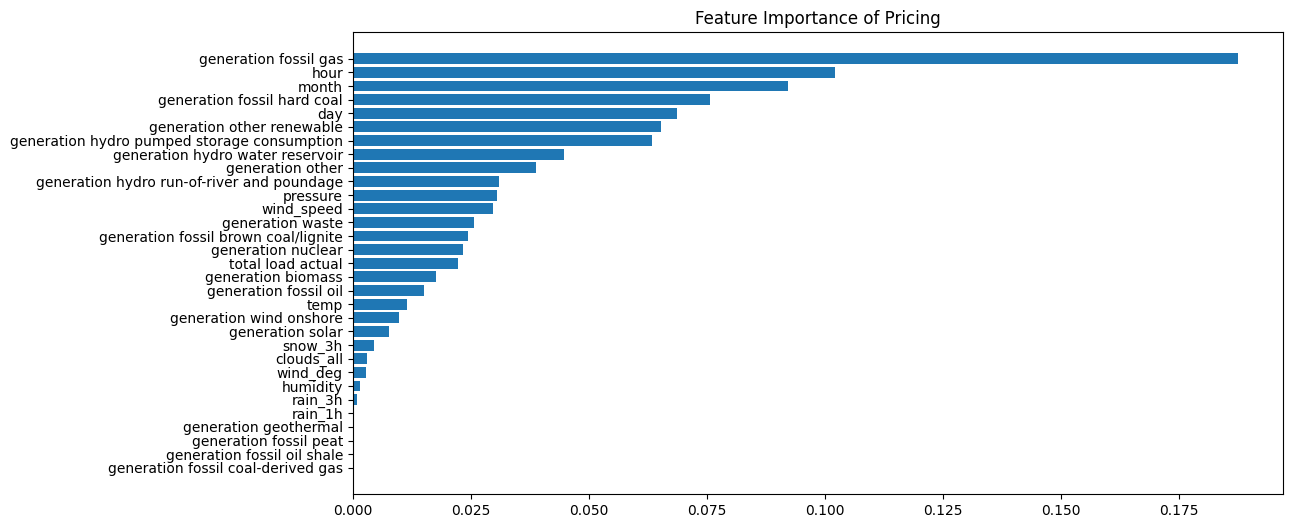

In [36]:
#get important features
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

#create graph
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance of Pricing')